In [109]:
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
# Example path - update it as per your drive

data_path = '/content/drive/MyDrive/Mental Health Dataset.csv'
df = pd.read_csv(data_path)
df.head()


,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
0,8/27/2014 11:29,Female,United States,Corporate,NaN,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,8/27/2014 11:31,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,8/27/2014 11:32,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,8/27/2014 11:37,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,8/27/2014 11:43,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes


In [111]:
df = df.drop(columns=['Timestamp'])


le = LabelEncoder()
cat_cols = ['Gender', 'Country', 'Occupation', 'self_employed', 'family_history',
            'Mental_Health_History', 'Mood_Swings', 'Coping_Struggles', 'Work_Interest',
            'Social_Weakness', 'mental_health_interview', 'care_options', 'Growing_Stress',
            'Changes_Habits', 'Days_Indoors']

for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Encode the target column
df['treatment'] = le.fit_transform(df['treatment'].astype(str))

# Train-test split
X = df.drop(columns=['treatment'])
y = df['treatment']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression
model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear',max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, solver='liblinear')

In [112]:
from sklearn.model_selection import GridSearchCV

params = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear']
}

grid = GridSearchCV(LogisticRegression(max_iter=1000), params, cv=5, scoring='f1')
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
model = grid.best_estimator_


Best Params: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


In [113]:
# Handle Class Imbalance

y.value_counts(normalize=True)


,proportion
treatment,
1,0.504871
0,0.495129


              precision    recall  f1-score   support

           0       0.70      0.69      0.70     28895
           1       0.70      0.72      0.71     29578

    accuracy                           0.70     58473
   macro avg       0.70      0.70      0.70     58473
weighted avg       0.70      0.70      0.70     58473



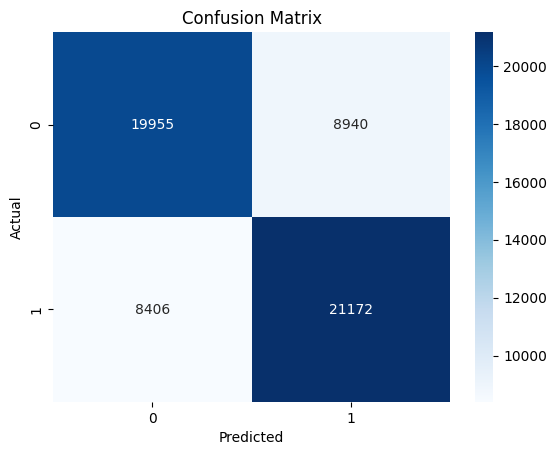

ROC-AUC Score: 0.7557043239989651
F1 Score: 0.7093985592226504


In [114]:
# Model Validation and Evaluation

grid.fit(X_train, y_train)  # This trains the model

model = grid.best_estimator_  # This is your trained model

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


print("F1 Score:", f1_score(y_test, y_pred))



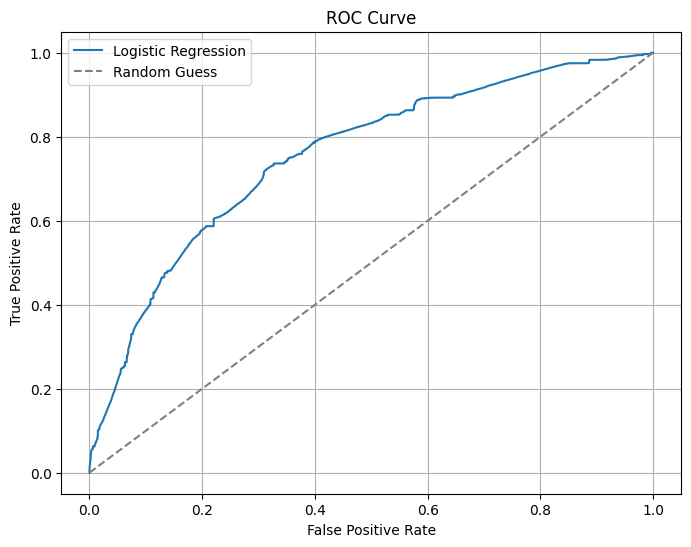

Thresholds: [       inf 0.93200774 0.93116012 0.93114841 0.93100637]


In [117]:


fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

print("Thresholds:", thresholds[:5])  # just the first 5 to peek

